# TDA Thesis

### Import Libraries

In [1]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)
import matplotlib.pyplot as plt
# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn as sk
import pylab

### Import Datasets

In [5]:
pba_ph_2023 = pd.read_csv('../data/2022-2023-PBA-PH-Cup-2022-2023.csv')
pba_ph_2023.rename(columns= {"3:00 PM": "3 PM"}, inplace= True)
pba_ph_2023.head()

,#,Player,Position,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
0,1,Robert Bolick,PG,NPB,8,34.4,18.5,6.5,15.3,0.426,...,3.6,0.759,1.6,4.3,5.9,5.6,0.4,0.3,1.8,0.6
1,2,Kevin Alas,PG,NLEX,11,33.5,17.5,5.9,12.3,0.481,...,5.5,0.639,1.5,3.9,5.4,5.4,1.2,0.0,3.4,2.3
2,3,Jayson Castro William,PG,TNT,24,26.5,14.7,4.5,9.2,0.486,...,5.3,0.817,1.0,3.1,4.1,4.3,1.0,0.2,2.0,2.0
3,4,Aaron Black,PG,MER,20,32.6,14.6,5.6,12.6,0.440,...,2.8,0.625,0.8,4.4,5.2,4.4,0.3,0.1,2.0,1.8
4,5,Roi Sumang,PG,NPB,11,31.7,13.5,5.1,10.5,0.487,...,1.1,1.000,0.9,3.4,4.3,6.5,1.4,0.0,2.3,2.2


In [7]:
len(pba_ph_2023)

137

## Mapper Algorithm

### Preprocess the dataset

In [11]:
dicti = {'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5}
azavedo_f = ['FGM', 'FGA', '3 PM', '3PA', 'FTM', 'FTA', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG'] #features suggested by azavedo

def preprocess(dataset, features, dicti):
    df_num_var = pba_ph_2023.select_dtypes(include=['number']).drop('#', axis=1)
    df_final = df_num_var[features]
    df_scaled = sk.preprocessing.scale(df_final)
    pca = sk.decomposition.PCA(n_components=2, whiten=True)
    df_transformed = pca.fit_transform(df_scaled)
      
    filterDim1 = pd.Series(df_transformed[:,0], name='Dim1')
    filterDim2 = pd.Series(df_transformed[:,1], name='Dim2')
    df_withFilter = pd.concat([filterDim1,filterDim2,df_final],axis=1)

    invdict = {v: k for k, v in dicti.items()}
    positions = list(pba_ph_2023['Position'])
    position_labels = [dicti[x] for x in positions]
    return df_transformed, position_labels, invdict, df_withFilter

df_transformed, position_labels, invdict, df_withFilter = preprocess(pba_ph_2023, azavedo_f, dicti)



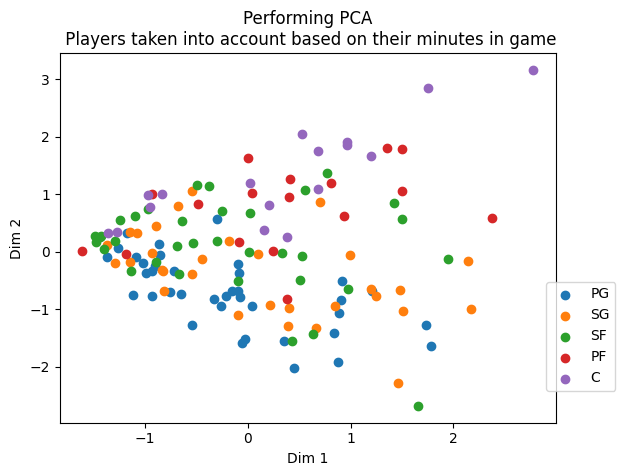

In [12]:
def plot_pca_with_labels(df_transformed, position_labels, invdict):
    plt.title("Performing PCA\n Players taken into account based on their minutes in game")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")

    states = [invdict[x] for x in [1, 2, 3, 4, 5]]
    for i, l in enumerate(states):
        x = []
        y = []
        for j, _ in enumerate(df_transformed[:, 0]):
            if position_labels[j] == i + 1:
                x.append(df_transformed[j, 0])
                y.append(df_transformed[j, 1])
        plt.scatter(x, y, label=l)

    plt.legend(loc='upper center', bbox_to_anchor=(1.05, .4), scatterpoints=1)
    plt.show()
    
plot_pca_with_labels(df_transformed, position_labels, invdict)

In [13]:
# Define filter function – can be any scikit-learn transformer
filter_func = PCA(n_components=2)
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)


In [ ]:
color_data = pd.get_dummies(pba_ph_2023["Position"], prefix="Position")
MIP = MapperInteractivePlotter(pipe, df_withFilter)
# Generate interactive widget
MIP.plot(color_data=color_data)

In [15]:
x = MIP.graph_.vs[45]["node_elements"]
members = pba_ph_2023.iloc[x]
members

,#,Player,Position,Team,GP,MPG,PPG,FGM,FGA,FG%,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
87,19,Larry Muyang,SF,FUEL,11,13.0,5.7,2.2,3.4,0.649,...,2.0,0.682,1.9,2.3,4.2,0.2,0.3,0.2,0.5,2.4


In [ ]:
# TODO: combine all? with League coloring